In this notebook, we try to classify X-ray images to classify if a patient has pneumonia or not instead of trying to classify symtomatic COVID-19 altogether. I will use Tensorflow version 2.6.0

Load Tensorflow

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
import pandas as pd
import numpy as np
import random
import os
from glob import glob
from PIL import Image
import pathlib

import tensorflow as tf
print("TensorFlow version:", tf.__version__)

from tensorflow.keras.layers import Dense, Flatten, Conv2D
from tensorflow.keras import utils
from tensorflow.keras import Model

batch_size = 32

TensorFlow version: 2.6.0


Load my custom helper functions and preview the data

In [2]:
from src.datareader import get_metadata, get_summary_data
from src.find_images_without_metadata import find_images_without_metadata
from src.labelenums import Label
from src.plotting import plot_confusion_matrix

In [3]:
metadata: pd.DataFrame = get_metadata()
summarydata: pd.DataFrame = get_summary_data()
print(summarydata)

      Label Label_2_Virus_category Label_1_Virus_category  Image_Count
0    Normal                                                       1576
1  Pnemonia         Stress-Smoking                   ARDS            2
2  Pnemonia                  Virus                                1493
3  Pnemonia                  Virus               COVID-19           58
4  Pnemonia                  Virus                   SARS            4
5  Pnemonia               bacteria                                2772
6  Pnemonia               bacteria          Streptococcus            5


In [4]:
metadata.head()

,X_ray_image_name,Label,Dataset_type,Label_2_Virus_category,Label_1_Virus_category
0,IM-0128-0001.jpeg,Normal,TRAIN,,
1,IM-0127-0001.jpeg,Normal,TRAIN,,
2,IM-0125-0001.jpeg,Normal,TRAIN,,
3,IM-0122-0001.jpeg,Normal,TRAIN,,
4,IM-0119-0001.jpeg,Normal,TRAIN,,


Let's verify that all the images are in the metadata, else we could run into issues if not careful. If you run into any problems, stop here and fix them.

In [5]:
for dataset in ['TRAIN', 'TEST']:
    extra_files = find_images_without_metadata(dataset)
    if len(extra_files) == 0:
        continue
    for file_name in extra_files:
        fullname = os.path.join(os.getcwd(), 'dataset', dataset, file_name)
        if os.path.isfile(fullname):
            print('Removing file: ' + fullname)
            os.remove(fullname)
    find_images_without_metadata(dataset)


Both lists match for the TRAIN dataset
Both lists match for the TEST dataset


Separate between training and testing

In [6]:
train_sample = metadata.loc[metadata['Dataset_type'] == 'TRAIN']
test_sample = metadata.loc[metadata['Dataset_type'] == 'TEST']
train_path = os.path.join(os.getcwd(), 'dataset', 'TRAIN')
test_path = os.path.join(os.getcwd(), 'dataset', 'TEST')

Preview some images in the training data

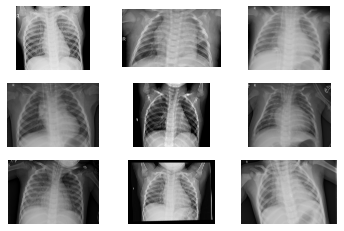

In [7]:
fig, axes = plt.subplots(3, 3, squeeze=False, )
random_image_indices = random.sample(range(len(train_sample)), 9)
image_names = list(train_sample.iloc[random_image_indices]['X_ray_image_name'])
for n in range(9):
    this_axis = axes[n//3, n%3]
    filename = os.path.join(train_path, image_names[n])
    img = mpimg.imread(filename)
    imgplot = this_axis.imshow(img, cmap='gray')
    this_axis.axis('off')


As you can see, the images are not uniform in shape, so we still have some preprocessing to do

In [8]:
image_size_counter = {}
for basename in train_sample['X_ray_image_name']:
    filename = os.path.join(train_path, basename)
    size = Image.open(filename).size
    if size in image_size_counter.keys():
        image_size_counter[(size, size[0] * size[1])] += 1
    else:
        image_size_counter[(size, size[0] * size[1])] = 1
smallest_picture_index = np.argmin([x[1] for x in list(image_size_counter.keys())])
largest_picture_index = np.argmax([x[1] for x in list(image_size_counter.keys())])
print('Smallest image size: ', list(image_size_counter.keys())[smallest_picture_index][0])
print('Large image size: ', list(image_size_counter.keys())[largest_picture_index][0])

Smallest image size:  (384, 127)
Large image size:  (4248, 3480)


Since the images differ widely in size, we must resort to resizing them and normalizing them.

In [9]:
new_size = (256, 256)
AUTOTUNE = tf.data.AUTOTUNE
class_names = np.unique(np.array(train_sample['Label']))
normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)
labeler = Label()


def get_train_label(file_path):
    # Convert the path to a list of path components
    filename = os.path.basename(file_path)
    copy = train_sample.copy()
    names_ds = list(copy['X_ray_image_name'].copy())
    labels_ds = list(copy['Label'].copy())
    label_str = labels_ds[names_ds.index(filename)]
    label_int = labeler[label_str]
    return [label_int]


def get_test_label(file_path):
    # Convert the path to a list of path components
    filename = os.path.basename(file_path)
    copy = test_sample.copy()
    names_ds = list(copy['X_ray_image_name'].copy())
    labels_ds = list(copy['Label'].copy())
    label_str = labels_ds[names_ds.index(filename)]
    label_int = labeler[label_str]
    return [label_int]


def process_path(file_path, label):
    img1 = tf.io.read_file(file_path)
    img2 = tf.io.decode_png(img1, channels=1)
    img3 = tf.image.resize(img2, new_size, method='lanczos3', antialias=True)
    img4 = normalization_layer(img3)
    return img4, label


In [10]:
train_images = os.listdir(train_path)
num_train_images = len(train_images)
# train_image_indices = np.arange(num_train_images)
# np.random.shuffle(train_image_indices)
train_images_fullpaths = [
    os.path.join(train_path, image_name)
    for image_name in train_images
]

test_images = os.listdir(test_path)
num_test_images = len(test_images)
# test_image_indices = np.arange(num_test_images)
# np.random.shuffle(test_image_indices)
test_images_fullpaths = [
    os.path.join(test_path, image_name) 
    for image_name in test_images
]

train_labels = np.array([get_train_label(x) for x in train_images_fullpaths], 
                        dtype=int)
test_labels = np.array([get_test_label(x) for x in test_images_fullpaths], 
                       dtype=int)

Let's verify that each tain/test image has a label

In [11]:
for index in range(num_train_images):
    print(train_images[index], train_labels[index])

01E392EE-69F9-4E33-BFCE-E5C968654078.jpeg [1]
1-s2.0-S0140673620303706-fx1_lrg.jpg [1]
1-s2.0-S0929664620300449-gr2_lrg-a.jpg [1]
1-s2.0-S0929664620300449-gr2_lrg-b.jpg [1]
1-s2.0-S0929664620300449-gr2_lrg-c.jpg [1]
1-s2.0-S0929664620300449-gr2_lrg-d.jpg [1]
1-s2.0-S1684118220300608-main.pdf-001.jpg [1]
1-s2.0-S1684118220300608-main.pdf-002.jpg [1]
1-s2.0-S1684118220300682-main.pdf-002-a1.png [1]
1-s2.0-S1684118220300682-main.pdf-002-a2.png [1]
1-s2.0-S1684118220300682-main.pdf-003-b1.png [1]
1-s2.0-S1684118220300682-main.pdf-003-b2.png [1]
1312A392-67A3-4EBF-9319-810CF6DA5EF6.jpeg [1]
171CB377-62FF-4B76-906C-F3787A01CB2E.jpeg [1]
1B734A89-A1BF-49A8-A1D3-66FAFA4FAC5D.jpeg [1]
23E99E2E-447C-46E5-8EB2-D35D12473C39.png [1]
2C10A413-AABE-4807-8CCE-6A2025594067.jpeg [1]
2C26F453-AF3B-4517-BB9E-802CF2179543.jpeg [1]
31BA3780-2323-493F-8AED-62081B9C383B.jpeg [1]
35AF5C3B-D04D-4B4B-92B7-CB1F67D83085.jpeg [1]
39EE8E69-5801-48DE-B6E3-BE7D1BCF3092.jpeg [1]
41591_2020_819_Fig1_HTML.webp-day10.png 

NORMAL2-IM-0668-0001.jpeg [0]
NORMAL2-IM-0669-0001.jpeg [0]
NORMAL2-IM-0671-0001.jpeg [0]
NORMAL2-IM-0672-0001.jpeg [0]
NORMAL2-IM-0673-0001.jpeg [0]
NORMAL2-IM-0675-0001.jpeg [0]
NORMAL2-IM-0678-0001.jpeg [0]
NORMAL2-IM-0680-0001.jpeg [0]
NORMAL2-IM-0682-0001.jpeg [0]
NORMAL2-IM-0683-0001.jpeg [0]
NORMAL2-IM-0684-0001-0001.jpeg [0]
NORMAL2-IM-0686-0001.jpeg [0]
NORMAL2-IM-0687-0001.jpeg [0]
NORMAL2-IM-0689-0001.jpeg [0]
NORMAL2-IM-0690-0001.jpeg [0]
NORMAL2-IM-0692-0001.jpeg [0]
NORMAL2-IM-0693-0001.jpeg [0]
NORMAL2-IM-0694-0001.jpeg [0]
NORMAL2-IM-0695-0001.jpeg [0]
NORMAL2-IM-0696-0001.jpeg [0]
NORMAL2-IM-0698-0001.jpeg [0]
NORMAL2-IM-0699-0001.jpeg [0]
NORMAL2-IM-0700-0001.jpeg [0]
NORMAL2-IM-0702-0001.jpeg [0]
NORMAL2-IM-0705-0001.jpeg [0]
NORMAL2-IM-0707-0001.jpeg [0]
NORMAL2-IM-0718-0001.jpeg [0]
NORMAL2-IM-0719-0001.jpeg [0]
NORMAL2-IM-0723-0001.jpeg [0]
NORMAL2-IM-0725-0001.jpeg [0]
NORMAL2-IM-0727-0001.jpeg [0]
NORMAL2-IM-0730-0001.jpeg [0]
NORMAL2-IM-0736-0001.jpeg [0]
NORMA

person1220_bacteria_3174.jpeg [1]
person1220_virus_2068.jpeg [1]
person1222_bacteria_3177.jpeg [1]
person1222_virus_2071.jpeg [1]
person1223_bacteria_3178.jpeg [1]
person1223_virus_2073.jpeg [1]
person1224_virus_2074.jpeg [1]
person1225_bacteria_3180.jpeg [1]
person1225_virus_2076.jpeg [1]
person1226_virus_2077.jpeg [1]
person1227_bacteria_3182.jpeg [1]
person1227_virus_2078.jpeg [1]
person1228_bacteria_3183.jpeg [1]
person1228_virus_2079.jpeg [1]
person1229_virus_2080.jpeg [1]
person122_virus_229.jpeg [1]
person1230_bacteria_3185.jpeg [1]
person1230_virus_2081.jpeg [1]
person1231_bacteria_3186.jpeg [1]
person1231_virus_2088.jpeg [1]
person1232_virus_2089.jpeg [1]
person1233_bacteria_3188.jpeg [1]
person1233_virus_2090.jpeg [1]
person1234_bacteria_3189.jpeg [1]
person1234_bacteria_3190.jpeg [1]
person1234_virus_2093.jpeg [1]
person1235_bacteria_3191.jpeg [1]
person1235_virus_2095.jpeg [1]
person1236_bacteria_3192.jpeg [1]
person1236_virus_2096.jpeg [1]
person1237_bacteria_3193.jpeg [1]

person1596_bacteria_4184.jpeg [1]
person1597_bacteria_4187.jpeg [1]
person1597_bacteria_4188.jpeg [1]
person1597_bacteria_4189.jpeg [1]
person1597_bacteria_4190.jpeg [1]
person1597_bacteria_4191.jpeg [1]
person1597_bacteria_4192.jpeg [1]
person1597_bacteria_4193.jpeg [1]
person1597_bacteria_4194.jpeg [1]
person1598_bacteria_4195.jpeg [1]
person1598_bacteria_4197.jpeg [1]
person1598_bacteria_4198.jpeg [1]
person1599_bacteria_4200.jpeg [1]
person1599_bacteria_4201.jpeg [1]
person1599_virus_2775.jpeg [1]
person1599_virus_2776.jpeg [1]
person15_bacteria_52.jpeg [1]
person1600_bacteria_4202.jpeg [1]
person1600_virus_2777.jpeg [1]
person1601_bacteria_4209.jpeg [1]
person1601_bacteria_4212.jpeg [1]
person1602_bacteria_4218.jpeg [1]
person1602_virus_2780.jpeg [1]
person1603_virus_2781.jpeg [1]
person1604_virus_2782.jpeg [1]
person1605_bacteria_4226.jpeg [1]
person1607_bacteria_4232.jpeg [1]
person1607_virus_2785.jpeg [1]
person1608_bacteria_4235.jpeg [1]
person1609_bacteria_4236.jpeg [1]
perso

person364_bacteria_1656.jpeg [1]
person364_bacteria_1657.jpeg [1]
person364_bacteria_1658.jpeg [1]
person364_bacteria_1659.jpeg [1]
person364_bacteria_1660.jpeg [1]
person364_virus_743.jpeg [1]
person365_virus_745.jpeg [1]
person366_bacteria_1664.jpeg [1]
person366_virus_746.jpeg [1]
person367_bacteria_1665.jpeg [1]
person367_virus_747.jpeg [1]
person368_bacteria_1666.jpeg [1]
person368_bacteria_1667.jpeg [1]
person368_bacteria_1668.jpeg [1]
person368_bacteria_1672.jpeg [1]
person368_bacteria_1678.jpeg [1]
person368_virus_748.jpeg [1]
person369_bacteria_1680.jpeg [1]
person369_virus_750.jpeg [1]
person36_bacteria_182.jpeg [1]
person36_bacteria_183.jpeg [1]
person36_bacteria_184.jpeg [1]
person36_bacteria_185.jpeg [1]
person370_bacteria_1687.jpeg [1]
person370_bacteria_1688.jpeg [1]
person370_bacteria_1689.jpeg [1]
person370_bacteria_1690.jpeg [1]
person370_bacteria_1691.jpeg [1]
person370_bacteria_1692.jpeg [1]
person370_virus_752.jpeg [1]
person370_virus_753.jpeg [1]
person371_bacteri

person58_bacteria_276.jpeg [1]
person58_bacteria_277.jpeg [1]
person58_bacteria_278.jpeg [1]
person590_bacteria_2428.jpeg [1]
person590_virus_1138.jpeg [1]
person591_bacteria_2429.jpeg [1]
person591_virus_1139.jpeg [1]
person592_bacteria_2431.jpeg [1]
person592_bacteria_2434.jpeg [1]
person592_virus_1141.jpeg [1]
person593_bacteria_2435.jpeg [1]
person593_virus_1142.jpeg [1]
person594_bacteria_2436.jpeg [1]
person594_virus_1145.jpeg [1]
person595_bacteria_2438.jpeg [1]
person595_virus_1147.jpeg [1]
person596_bacteria_2440.jpeg [1]
person596_bacteria_2441.jpeg [1]
person596_bacteria_2443.jpeg [1]
person596_bacteria_2444.jpeg [1]
person596_bacteria_2445.jpeg [1]
person596_bacteria_2446.jpeg [1]
person596_bacteria_2447.jpeg [1]
person596_bacteria_2449.jpeg [1]
person596_virus_1149.jpeg [1]
person597_bacteria_2450.jpeg [1]
person597_bacteria_2451.jpeg [1]
person597_virus_1150.jpeg [1]
person598_bacteria_2453.jpeg [1]
person598_bacteria_2454.jpeg [1]
person598_virus_1151.jpeg [1]
person598_

In [12]:
for index in range(num_test_images):
    print(test_images[index], test_labels[index])

IM-0001-0001.jpeg [0]
IM-0003-0001.jpeg [0]
IM-0005-0001.jpeg [0]
IM-0006-0001.jpeg [0]
IM-0007-0001.jpeg [0]
IM-0009-0001.jpeg [0]
IM-0010-0001.jpeg [0]
IM-0011-0001-0001.jpeg [0]
IM-0011-0001-0002.jpeg [0]
IM-0011-0001.jpeg [0]
IM-0013-0001.jpeg [0]
IM-0015-0001.jpeg [0]
IM-0016-0001.jpeg [0]
IM-0017-0001.jpeg [0]
IM-0019-0001.jpeg [0]
IM-0021-0001.jpeg [0]
IM-0022-0001.jpeg [0]
IM-0023-0001.jpeg [0]
IM-0025-0001.jpeg [0]
IM-0027-0001.jpeg [0]
IM-0028-0001.jpeg [0]
IM-0029-0001.jpeg [0]
IM-0030-0001.jpeg [0]
IM-0031-0001.jpeg [0]
IM-0033-0001-0001.jpeg [0]
IM-0033-0001-0002.jpeg [0]
IM-0033-0001.jpeg [0]
IM-0035-0001.jpeg [0]
IM-0036-0001.jpeg [0]
IM-0037-0001.jpeg [0]
IM-0039-0001.jpeg [0]
IM-0041-0001.jpeg [0]
IM-0043-0001.jpeg [0]
IM-0045-0001.jpeg [0]
IM-0046-0001.jpeg [0]
IM-0049-0001.jpeg [0]
IM-0050-0001.jpeg [0]
IM-0059-0001.jpeg [0]
IM-0061-0001.jpeg [0]
IM-0063-0001.jpeg [0]
IM-0065-0001.jpeg [0]
IM-0067-0001.jpeg [0]
IM-0069-0001.jpeg [0]
IM-0070-0001.jpeg [0]
IM-0071-0001

In [13]:
train_image_paths_tensors = tf.convert_to_tensor(train_images_fullpaths, dtype=tf.string)
train_labels_tensors = tf.convert_to_tensor(train_labels)
train_dataset = tf.data.Dataset.from_tensor_slices((train_image_paths_tensors, train_labels_tensors))
train_dataset = train_dataset.map(process_path, num_parallel_calls=AUTOTUNE)

test_image_paths_tensors = tf.convert_to_tensor(test_images_fullpaths, dtype=tf.string)
test_labels_tensors = tf.convert_to_tensor(test_labels)
test_dataset = tf.data.Dataset.from_tensor_slices((test_image_paths_tensors, test_labels_tensors))
test_dataset = test_dataset.map(process_path, num_parallel_calls=AUTOTUNE)


print(tf.data.experimental.cardinality(train_dataset).numpy())
print(tf.data.experimental.cardinality(test_dataset).numpy())

5286
624


In [14]:
def configure_for_performance(ds):
  ds = ds.cache()
  ds = ds.shuffle(buffer_size=1000)
  ds = ds.batch(batch_size)
  ds = ds.prefetch(buffer_size=AUTOTUNE)
  return ds

train_dataset = configure_for_performance(train_dataset)
test_dataset = configure_for_performance(test_dataset)

In [29]:
metrics = [
    tf.keras.metrics.TruePositives(name='tp'),
    tf.keras.metrics.FalsePositives(name='fp'),
    tf.keras.metrics.TrueNegatives(name='tn'),
    tf.keras.metrics.FalseNegatives(name='fn'), 
#     tf.keras.metrics.MeanSquaredError(),
    tf.keras.metrics.BinaryAccuracy(),
#     tf.keras.metrics.CosineSimilarity(),
#     tf.keras.metrics.Recall(name='recall'),
    tf.keras.metrics.AUC(name='auc', curve='ROC')
]

Let's create a sequence deep neural-network with a 
 * Few convolutional layers to simplify the images
 * Max pooling to highlight the most important features (reflected X-rays)
 * Drop out to prevent over-training
 * A single dense layer with 64 nodes.
  * I could add more but the training times increases exponentially and I am using just my desktop
 * A final layer with a single node for the output classification class

In [30]:
filters = 10
kernel_size = (3, 3)
activation = 'relu'
# num_classes = len(class_names)
num_output_layer = 1

model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(filters, 
                           kernel_size=kernel_size, 
                           activation=activation,
                           strides=1,
                           padding='valid',
                           input_shape=(new_size[0], new_size[1], 1)),
    tf.keras.layers.Conv2D(filters,
                           kernel_size=kernel_size,
                           activation=activation),
    tf.keras.layers.Conv2D(filters,
                           kernel_size=kernel_size,
                           activation=activation),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation=activation),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(num_output_layer, activation='sigmoid')
])

Note that I played around with the filter size, dropout rate and number of dense layers.

I chose the loss function to be binary cross entropy since minimizing the cross-entropy is similar to maximizing the likelihood L as a function of parameters multiple parameters.

Let's look at the model summary.

In [31]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 254, 254, 10)      100       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 252, 252, 10)      910       
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 250, 250, 10)      910       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 125, 125, 10)      0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 156250)            0         
_________________________________________________________________
dense_6 (Dense)              (None, 64)                10000064  
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)               

It is straight forward if you are used to looking at tables like this, but I find it more useful to visual the model as a series of layers.

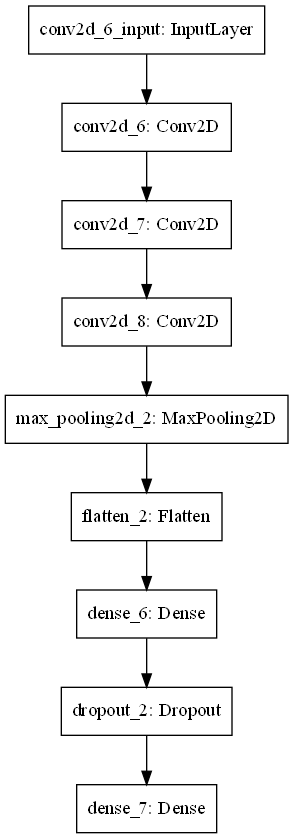

In [32]:
tf.keras.utils.plot_model(model)

In [33]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=metrics)

In [34]:
output_path = "training_has_pnemonia"
checkpoint_path = os.path.join(output_path, "cp.ckpt")
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)
# Create a callback that stops early
early_stoping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                 patience=10, 
                                                 restore_best_weights=True)

In [35]:
epochs = 10
model.fit(
    train_dataset,
    validation_data=test_dataset,
    epochs=epochs,
    callbacks=[cp_callback, early_stoping]
)

Epoch 1/10
166/166 [==============================] - 66s 388ms/step - loss: 0.2811 - tp: 3570.0000 - fp: 155.0000 - tn: 1187.0000 - fn: 374.0000 - binary_accuracy: 0.8999 - auc: 0.9596 - val_loss: 0.9958 - val_tp: 390.0000 - val_fp: 205.0000 - val_tn: 29.0000 - val_fn: 0.0000e+00 - val_binary_accuracy: 0.6715 - val_auc: 0.8971

Epoch 00001: saving model to training_has_pnemonia\cp.ckpt
Epoch 2/10
166/166 [==============================] - 65s 393ms/step - loss: 0.1228 - tp: 3847.0000 - fp: 108.0000 - tn: 1234.0000 - fn: 97.0000 - binary_accuracy: 0.9612 - auc: 0.9866 - val_loss: 1.4811 - val_tp: 388.0000 - val_fp: 190.0000 - val_tn: 44.0000 - val_fn: 2.0000 - val_binary_accuracy: 0.6923 - val_auc: 0.8043

Epoch 00002: saving model to training_has_pnemonia\cp.ckpt
Epoch 3/10
166/166 [==============================] - 65s 393ms/step - loss: 0.0843 - tp: 3872.0000 - fp: 68.0000 - tn: 1274.0000 - fn: 72.0000 - binary_accuracy: 0.9735 - auc: 0.9929 - val_loss: 1.6427 - val_tp: 389.0000 - v

The model does too well given it's simplicity, but there still significant over-training. Compared between the first and last training epoch, the test/validation results are relatively unchanged

| Metric          | Epoch/Iteration | Training | Validation |
|-----------------|:---------------:|---------:|-----------:|
| True-Positives  |        1        |  67.5%   | 62.5%      |
| False-Positives |        1        |   2.9%   | 32.8%      |
| True-Negatives  |        1        |  22.4%   | 4.6%       |
| False-Negatives |        1        |   7.1%   | 0%         |
| Binary Accuracy |        1        |  89.9%   | 67.1%      |

| Metric          | Epoch/Iteration | Training | Validation |
|-----------------|:---------------:|---------:|-----------:|
| True-Positives  |        10       |  74.2%   | 62.5%      |
| False-Positives |        10       |   0.4%   | 32.3%      |
| True-Negatives  |        10       |  24.9%   | 5.2%       |
| False-Negatives |        10       |   0.3%   | 0%         |
| Binary Accuracy |        10       |  99.2%   | 67.7%      |

Why is there over-training? The populations seem different. Maybe a deeper dive into the labels will explain that

In [50]:
labels = np.unique(train_sample['Label'].to_numpy())
print(labels)

['Normal' 'Pnemonia']


In [60]:
num_normals_train = train_sample[train_sample['Label'] == 'Normal'].shape[0]
num_normals_test = test_sample[test_sample['Label'] == 'Normal'].shape[0]
num_pnemonia_train = train_sample[train_sample['Label'] == 'Pnemonia'].shape[0]
num_pnemonia_test = test_sample[test_sample['Label'] == 'Pnemonia'].shape[0]

In [61]:
print(num_normals_train, num_pnemonia_train, num_normals_test, num_pnemonia_test)

1342 3944 234 390


By the numbers, we see that the training set has about 3x more pnemonia images than normal images, which certainly inserts a bias.

| Label    | Dataset | Count |
|----------|---------|------:|
| Normal   |  Train  | 1342  |
| Pnemonia |  Train  | 3944  |
| Normal   |  Test   | 234   |
| Pnemonia |  Test   | 390   |

If I were to redo this analysis without additional data, I would utilize bagging to mitigate the over-training results.